In [4]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [6]:
file_path = '215d3c1ea7d0c562774a8c6e4b157ac0.xlsx'
data = pd.ExcelFile(file_path)

In [7]:
data.sheet_names

['2022']

In [8]:
df = data.parse('2022')

In [9]:
columns_to_extract = [
    "Odczyn pH - wartość terenowa",
    "Temperatura - wartość terenowa [°C]",
]

start_column = "Ogólny węgiel organiczny [mgC/l]"
end_column = df.columns[-2]

columns_for_mineralization = df.loc[:, start_column:end_column]

columns_for_mineralization = columns_for_mineralization.replace({',': '.'}, regex=True)
columns_for_mineralization = columns_for_mineralization.replace({r'[<>]': ''}, regex=True)
columns_for_mineralization = columns_for_mineralization.apply(pd.to_numeric, errors='coerce')

In [10]:
columns_for_mineralization.head()

,Ogólny węgiel organiczny [mgC/l],Amonowy jon [mgNH4/l],Antymon [mgSb/l],Arsen [mgAs/l],Azotany [mgNO3/l],Azotyny [mgNO2/l],Bar [mgBa/l],Beryl [mgBe/l],Bor [mgB/l],Chlorki [mgCl/l],...,Siarczany [mgSO4/l],Sód [mgNa/l],Srebro [mgAg/l],Tal [mgTl/l],Tytan [mgTi/l],Uran [mgU/l],Wanad [mgV/l],Wapń [mgCa/l],Wodorowęglany [mgHCO3/l],Żelazo [mgFe/l]
0,14.0,1.04,0.00005,0.002,0.65,0.66,0.109,0.00005,0.10,332.0,...,34.60,204.7,0.00005,0.00005,0.003,0.00005,0.003,98.8,357.0,0.77
1,2.0,0.50,0.00005,0.002,0.19,0.04,0.073,0.00005,0.06,51.2,...,84.20,21.8,0.00005,0.00005,0.002,0.00005,0.001,99.5,244.0,1.85
2,2.0,1.13,0.00005,0.002,0.72,1.42,0.021,0.00005,1.00,800.0,...,6.95,622.7,0.00005,0.00005,0.002,0.00005,0.005,20.0,379.0,0.11
3,1.9,5.58,0.00005,0.002,0.05,0.06,0.276,0.00005,0.26,448.0,...,61.60,292.3,0.00005,0.00005,0.002,0.00005,0.002,105.5,467.0,1.54
4,15.0,3.51,0.00005,0.002,0.11,0.01,0.023,0.00005,0.10,19.5,...,7.47,15.1,0.00005,0.00005,0.002,0.00005,0.001,89.5,360.0,0.02


In [11]:
df_selected = df[columns_to_extract]

df_selected = df_selected.replace({',': '.'}, regex=True)
df_selected = df_selected.apply(pd.to_numeric, errors='coerce')

df_selected.columns = [
    "ph_field",
    "temp_field",
]

In [12]:
df_selected["mineralization"] = columns_for_mineralization.sum(axis=1)

In [14]:
range_column = "Przedział ujętej warstwy wodonośnej [m p.p.t.]"
range_data = df[range_column].dropna()

def calculate_mean_range(range_str):
    try:
        min_val, max_val = map(float, range_str.replace(',', '.').split('-'))
        return (min_val + max_val) / 2
    except Exception:
        return None
    
df_selected["depth"] = range_data.apply(calculate_mean_range)

In [34]:
df_selected.head()

,ph_field,temp_field,mineralization,depth
0,7.14,11.7,1063.71434,14.0
1,7.19,11.5,522.47648,28.0
2,7.76,11.7,1850.88460,45.0
3,7.51,12.1,1436.56268,27.1
4,7.15,10.0,539.03194,28.0


In [15]:
def plot_histogram(dataFrame):
  fig, axes = plt.subplots(2, 2, figsize=(12, 10))

  for ax, column in zip(axes.flatten(), dataFrame.columns):
      counts, bins, patches = ax.hist(dataFrame[column].dropna(), bins=30, edgecolor='black', alpha=0.7)

      for count, bin_patch in zip(counts, patches):
          x_pos = bin_patch.get_x() + bin_patch.get_width() / 2  # Center text
          ax.text(x_pos, count, str(int(count) if count != 0 else ''), ha='center', va='bottom', fontsize=10)

      # ax.hist(df_selected[column].dropna(), bins=30, edgecolor='black', alpha=0.7, histtype='step')
      ax.set_title(f"Histogram of {column}")
      ax.set_xlabel(column)
      ax.set_ylabel("Frequency")
      ax.grid(True)

  plt.tight_layout()
  plt.show()

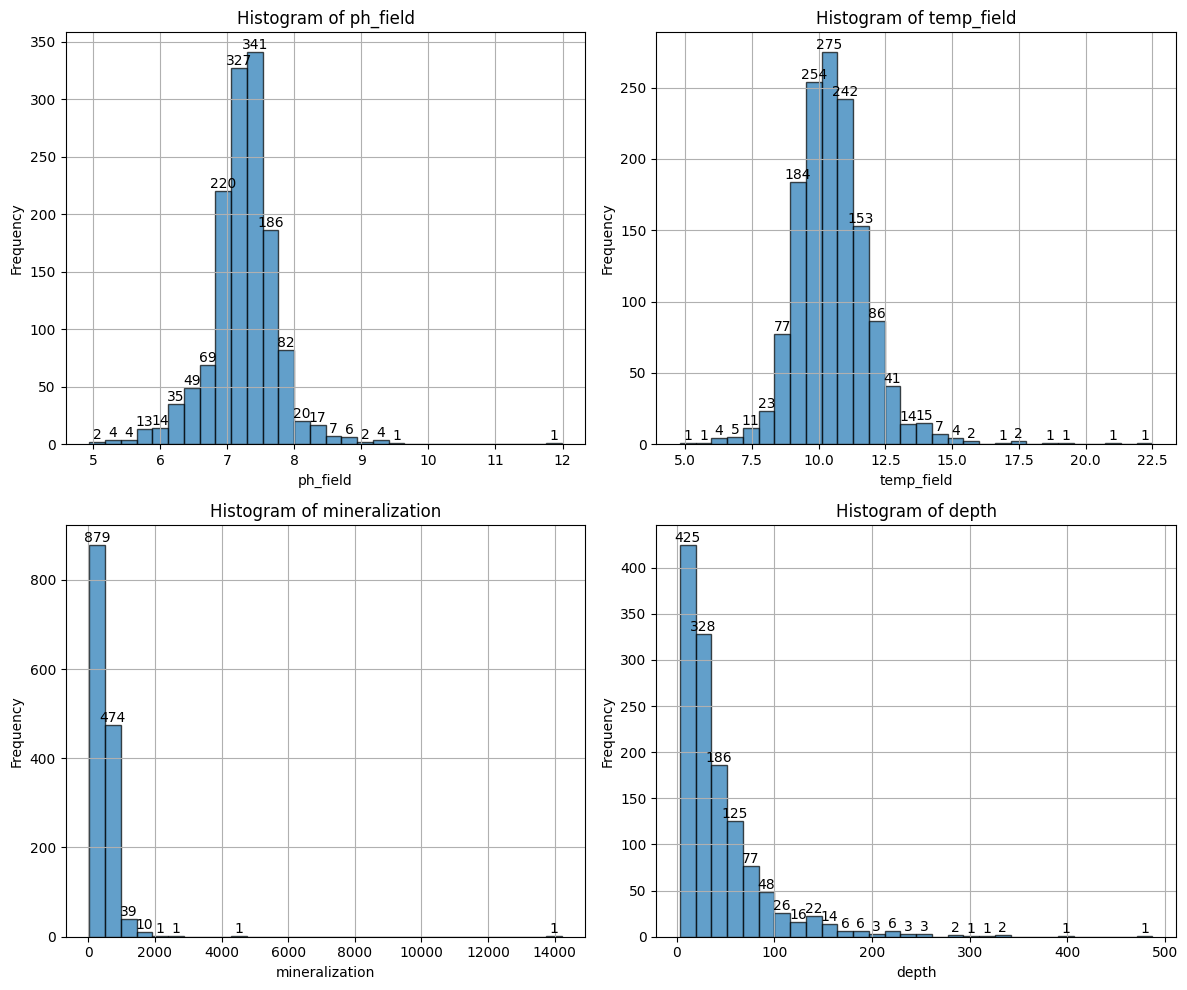

In [16]:
plot_histogram(df_selected)

In [32]:
thresholds = {'ph_field': 10, 'temp_field': 20.0, 'mineralization': 3000, 'depth': 375}

df_without_edge_values = df_selected.copy()

for column, threshold_value in thresholds.items():
    if column in df_without_edge_values.columns:
        df_without_edge_values = df_without_edge_values[df_without_edge_values[column] <= threshold_value]

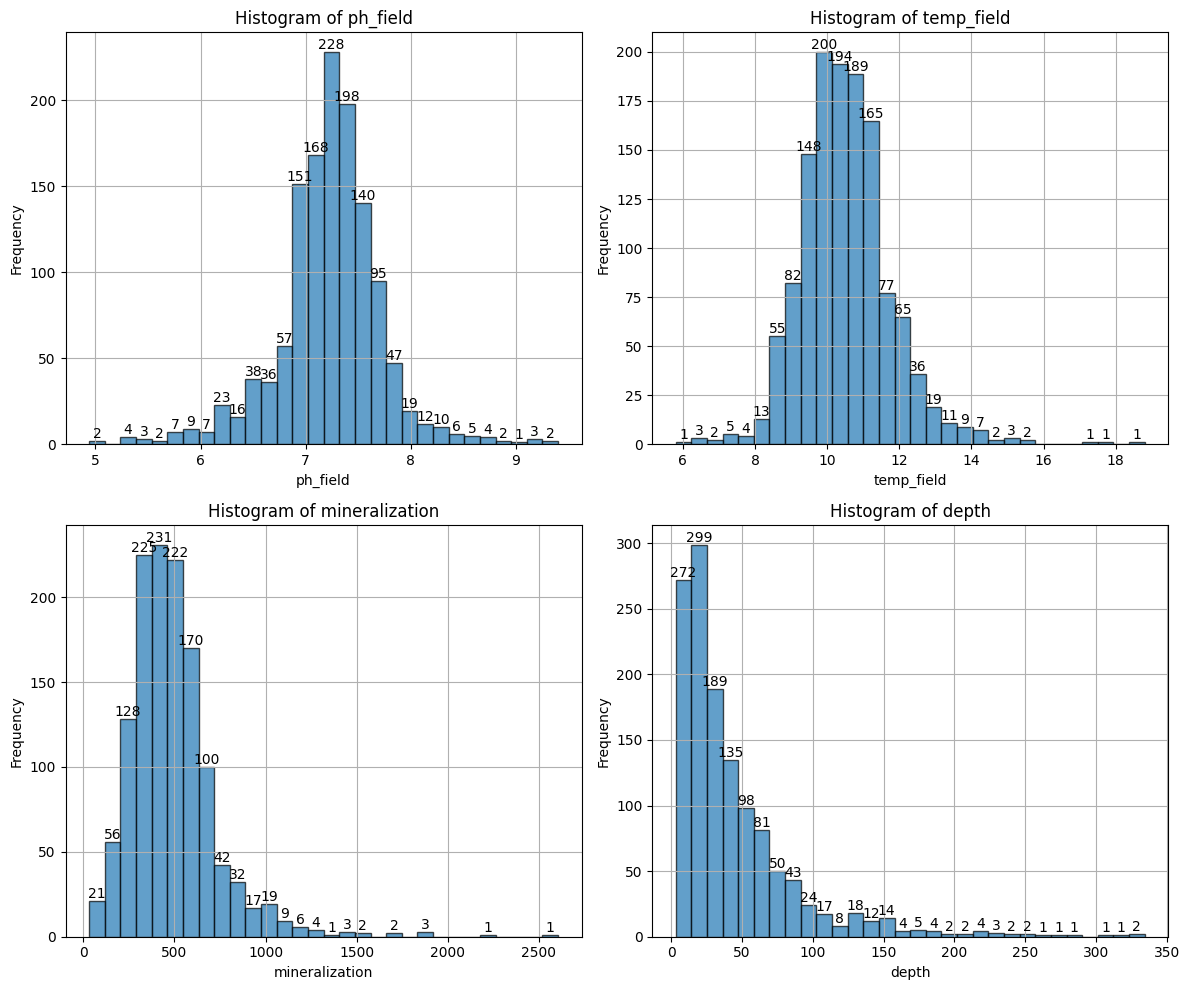

In [33]:
plot_histogram(df_without_edge_values)

pousuwac niektore skrajne wartosci, zeby poprawic skale
- im glebiej temperatura wieksza
- powyzej -> to wtedy mineralizacja wieksza
- 

In [17]:
def find_outliers(data, k, r):
    n = len(data)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = np.sqrt(np.sum((data[i] - data[j]) ** 2))

    sorted_indices = np.argsort(dist_matrix, axis=1)
    k_closest_indices = sorted_indices[:, 1:k+1]
    max_distances = np.zeros(n)

    for i in range(n):
        max_distances[i] = max(dist_matrix[i, k_closest_indices[i]])

    sorted_max_distances = np.sort(max_distances)
    threshold_index = int((1 - r) * n)
    threshold = sorted_max_distances[threshold_index]

    outliers = np.where(max_distances > threshold)[0]

    return outliers, max_distances

In [38]:
components = ['ph_field', 'temp_field', 'mineralization', 'depth']

def find_outlier_sets(dataframe, k, r):
  outlier_sets = []
  for component in components:
    outliers, max_distances = find_outliers(dataframe[component], k, r)
    # print(outliers)
    # print(len(outliers))
    outlier_sets.append(set(outliers))

  return outlier_sets

outlier_sets = find_outlier_sets(df_selected, k=10, r=0.01)

common_outliers = set.intersection(*outlier_sets)
print("Common Outliers:", common_outliers)
print("Number of Common Outliers:", len(common_outliers))

Common Outliers: set()
Number of Common Outliers: 0


In [ ]:
outliers, max_distances = find_outliers(df_selected['ph_field'], k=10, r=0.01)
print(outliers)
print(len(outliers))

[  65   74   79   89   91   94   96   98  112  113  115  120  126  128
  130  131  132  134  139  179  201  245  247  257  286  289  291  318
  328  351  368  425  449  464  478  547  628  713  737  757  774  779
  787  790  795  834  835  842  853  860  861  862  889  892  893  904
  948  949  950  951  953  956  958  963  964  967  973  985  986  987
 1000 1003 1006 1020 1022 1028 1029 1033 1039 1040 1042 1044 1051 1057
 1059 1060 1063 1064 1073 1079 1088 1092 1098 1132 1135 1157 1161 1177
 1194 1224 1230 1232 1237 1241 1261 1264 1271 1275 1277 1291 1294 1300
 1305 1328 1329 1339 1340 1344 1345 1355 1362 1363 1370 1375 1387 1388
 1398 1401 1402]
129


In [ ]:
outliers, max_distances = find_outliers(df_selected['temp_field'], k=10, r=0.01)
print(outliers)
print(len(outliers))

[  21   53   78   88  122  142  160  165  196  197  260  273  289  298
  368  380  392  394  419  431  528  530  578  580  582  594  596  626
  641  643  658  693  720  726  742  768  780  802  812  819  821  827
  836  841  849  869  938  947  987  997 1004 1026 1039 1044 1051 1053
 1098 1099 1106 1115 1151 1152 1153 1155 1160 1161 1164 1175 1197 1199
 1212 1241 1299 1320 1328 1347 1350 1374 1379 1380 1392 1397 1402]
83


In [ ]:
outliers, max_distances = find_outliers(df_selected['mineralization'], k=10, r=0.01)
print(outliers)
print(len(outliers))

[   0    2    3    5    6   11   12   16   21   31   63   69   81   98
  104  109  126  137  140  143  149  150  159  191  211  216  221  227
  228  229  275  277  328  341  363  390  392  396  405  407  409  413
  419  426  435  447  454  460  484  578  580  589  613  622  630  642
  651  658  660  663  678  679  680  693  725  728  740  773  795  798
  802  815  817  821  848  862  869  884  889  893  900  919  943  956
  961  971  980  985 1009 1015 1017 1029 1044 1048 1051 1059 1079 1085
 1090 1095 1104 1106 1112 1113 1114 1117 1123 1126 1129 1153 1154 1161
 1164 1199 1204 1206 1211 1215 1219 1228 1232 1233 1240 1244 1273 1279
 1281 1289 1291 1301 1302 1305 1310 1314 1319 1320 1326 1357 1361 1391]
140


In [ ]:
outliers, max_distances = find_outliers(df_selected['depth'], k=10, r=0.01)
print(outliers)
print(len(outliers))

[  96  111  113  114  134  162  277  347  371  513  535  636  643  660
  663  668  669  673  674  681  849  868  870  877  889  955  986  987
 1054 1091 1160 1175 1176 1240 1370]
35


In [43]:
def calculate_and_plot_outliers(dataframe, components, outlier_sets, k, r):
  for component, outliers in zip(components, outlier_sets):
      print(f'k = {k}, r = {r}, {len(outliers)}: {outliers}')

      y_values = np.zeros(len(dataframe[component]))
      plt.plot(dataframe[component], y_values, '|', label='Data', alpha=0.5)
      plt.plot(dataframe[component].iloc[list(outliers)], y_values[list(outliers)], '|', label='Outliers')
      plt.title(f"Plot of {component} with detected outliers")
      plt.xlabel("X Values")
      plt.ylabel("Y values")
      plt.legend()
      plt.show()

k = 10, r = 0.1, 129: {1028, 1029, 1033, 1039, 1040, 1042, 1044, 1051, 1057, 547, 1059, 1060, 1063, 1064, 1073, 1079, 1088, 65, 1092, 74, 1098, 79, 89, 91, 94, 96, 98, 1132, 1135, 112, 113, 115, 628, 120, 126, 128, 130, 131, 132, 1157, 134, 1161, 139, 1177, 1194, 179, 1224, 201, 713, 1230, 1232, 1237, 1241, 737, 1261, 1264, 245, 757, 247, 1271, 1275, 1277, 257, 774, 779, 1291, 1294, 787, 1300, 790, 1305, 795, 286, 289, 291, 1328, 1329, 1339, 1340, 318, 1344, 1345, 834, 835, 328, 842, 1355, 1362, 1363, 853, 1370, 860, 861, 862, 351, 1375, 1387, 1388, 368, 1398, 889, 1401, 1402, 892, 893, 904, 425, 948, 949, 950, 951, 953, 956, 958, 449, 963, 964, 967, 973, 464, 985, 986, 987, 478, 1000, 1003, 1006, 1020, 1022}


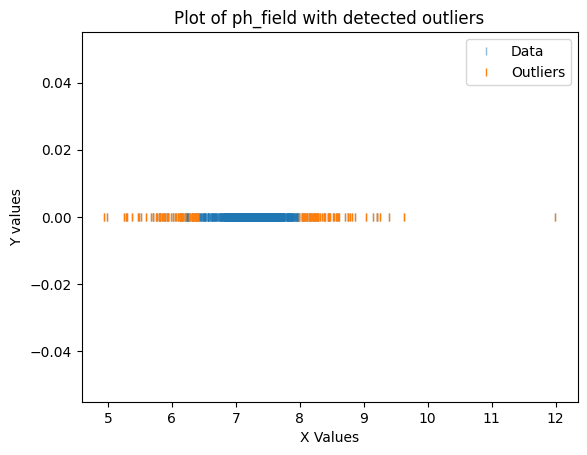

k = 10, r = 0.1, 83: {1026, 1039, 528, 530, 1044, 21, 1051, 1053, 53, 578, 580, 582, 1098, 1099, 78, 594, 1106, 596, 88, 1115, 626, 122, 1151, 1152, 641, 1153, 643, 1155, 1160, 1161, 1164, 142, 658, 1175, 160, 165, 1197, 1199, 693, 1212, 196, 197, 720, 726, 1241, 742, 768, 260, 780, 273, 1299, 289, 802, 1320, 298, 812, 1328, 819, 821, 827, 1347, 836, 1350, 841, 849, 1374, 1379, 1380, 869, 368, 1392, 1397, 1402, 380, 392, 394, 419, 938, 431, 947, 987, 997, 1004}


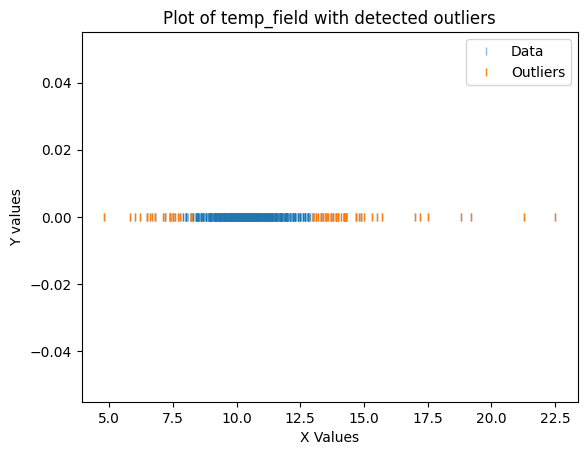

k = 10, r = 0.1, 140: {0, 2, 3, 5, 6, 1029, 11, 12, 16, 1044, 21, 1048, 1051, 31, 1059, 1079, 1085, 63, 578, 1090, 580, 69, 1095, 589, 1104, 81, 1106, 1112, 1113, 1114, 1117, 98, 1123, 613, 1126, 104, 1129, 109, 622, 630, 126, 1153, 642, 1154, 137, 1161, 651, 140, 1164, 143, 658, 660, 149, 150, 663, 159, 678, 679, 680, 1199, 1204, 693, 1206, 1211, 191, 1215, 1219, 1228, 1232, 1233, 211, 725, 216, 728, 1240, 1244, 221, 227, 228, 229, 740, 1273, 1279, 1281, 773, 1289, 1291, 275, 277, 1301, 1302, 1305, 795, 798, 1310, 802, 1314, 1319, 1320, 1326, 815, 817, 821, 328, 1357, 848, 1361, 341, 862, 869, 363, 1391, 884, 889, 893, 900, 390, 392, 396, 405, 407, 919, 409, 413, 419, 426, 943, 435, 956, 447, 961, 454, 971, 460, 980, 985, 484, 1009, 1015, 1017}


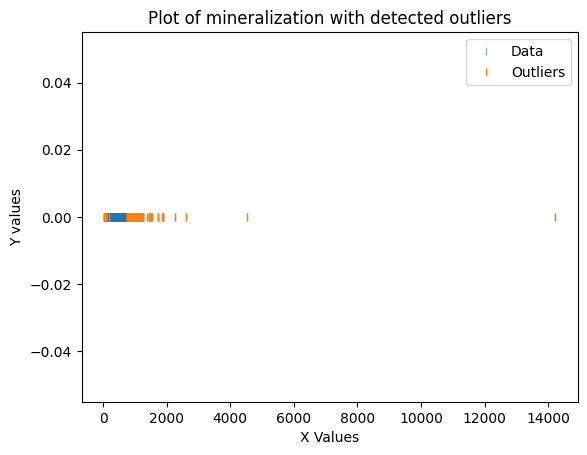

k = 10, r = 0.1, 35: {513, 643, 134, 1160, 660, 277, 663, 535, 1175, 1176, 668, 669, 1054, 673, 162, 674, 681, 955, 1091, 849, 1240, 986, 347, 987, 1370, 96, 868, 870, 877, 111, 113, 114, 371, 889, 636}


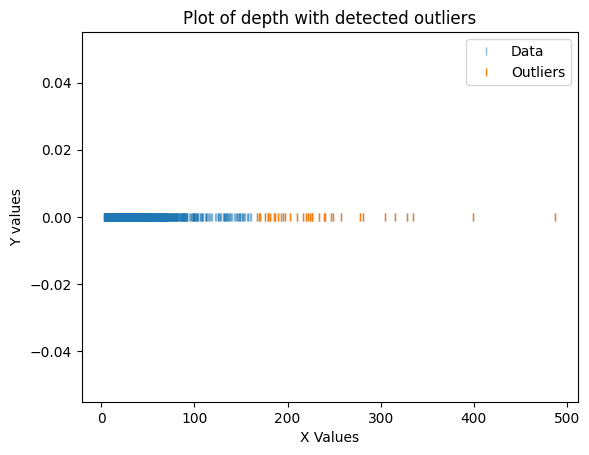

In [ ]:
calculate_and_plot_outliers(df_selected, components, outlier_sets)

standaryzacja/normalizacja

## Outliers after removing the most edge values

In [40]:
df_without_edge_values = df_without_edge_values.reset_index(drop=True)
cleaned_outlier_sets = find_outlier_sets(df_without_edge_values, k=10, r=0.01)

k = 10, r = 0.01, 12: {130, 964, 1002, 1101, 1230, 1262, 1268, 951, 1208, 1082, 988, 831}


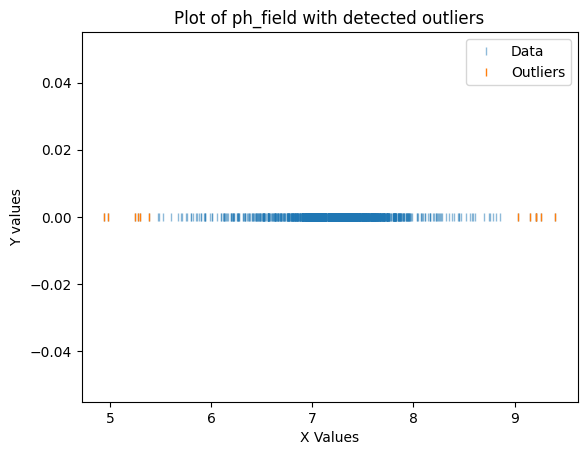

k = 10, r = 0.01, 12: {800, 161, 986, 1114, 794, 1288, 906, 820, 698, 283, 190, 671}


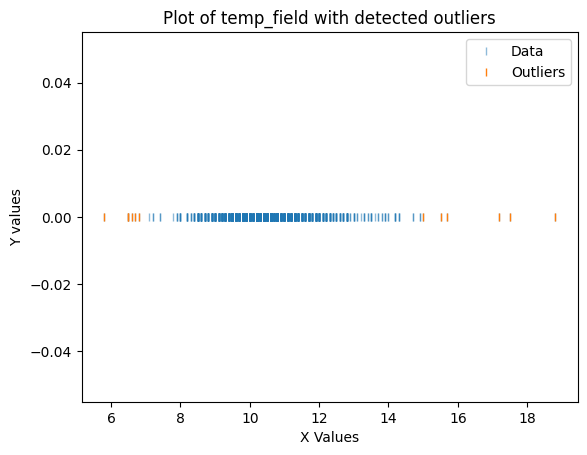

k = 10, r = 0.01, 12: {2, 3, 68, 643, 102, 1065, 396, 210, 564, 1206, 632, 155}


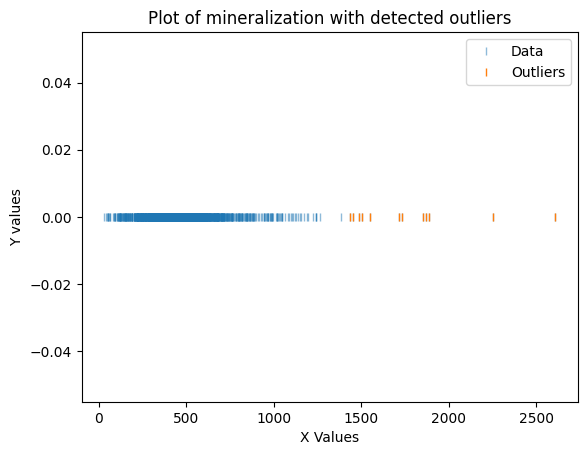

k = 10, r = 0.01, 12: {839, 361, 652, 846, 111, 1009, 660, 820, 1114, 923, 158, 95}


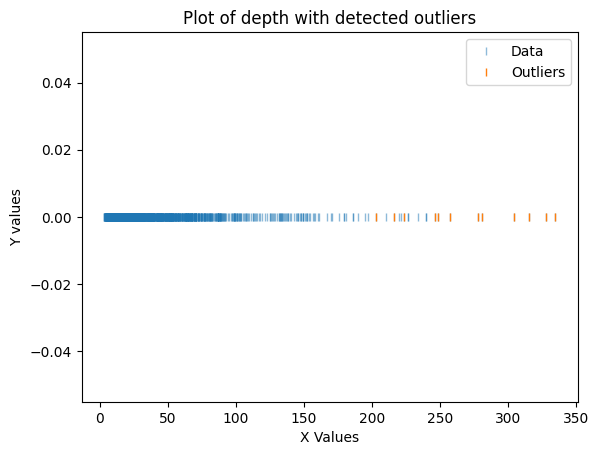

In [44]:
calculate_and_plot_outliers(df_without_edge_values, components, cleaned_outlier_sets, k=10, r=0.01)

## Standarization

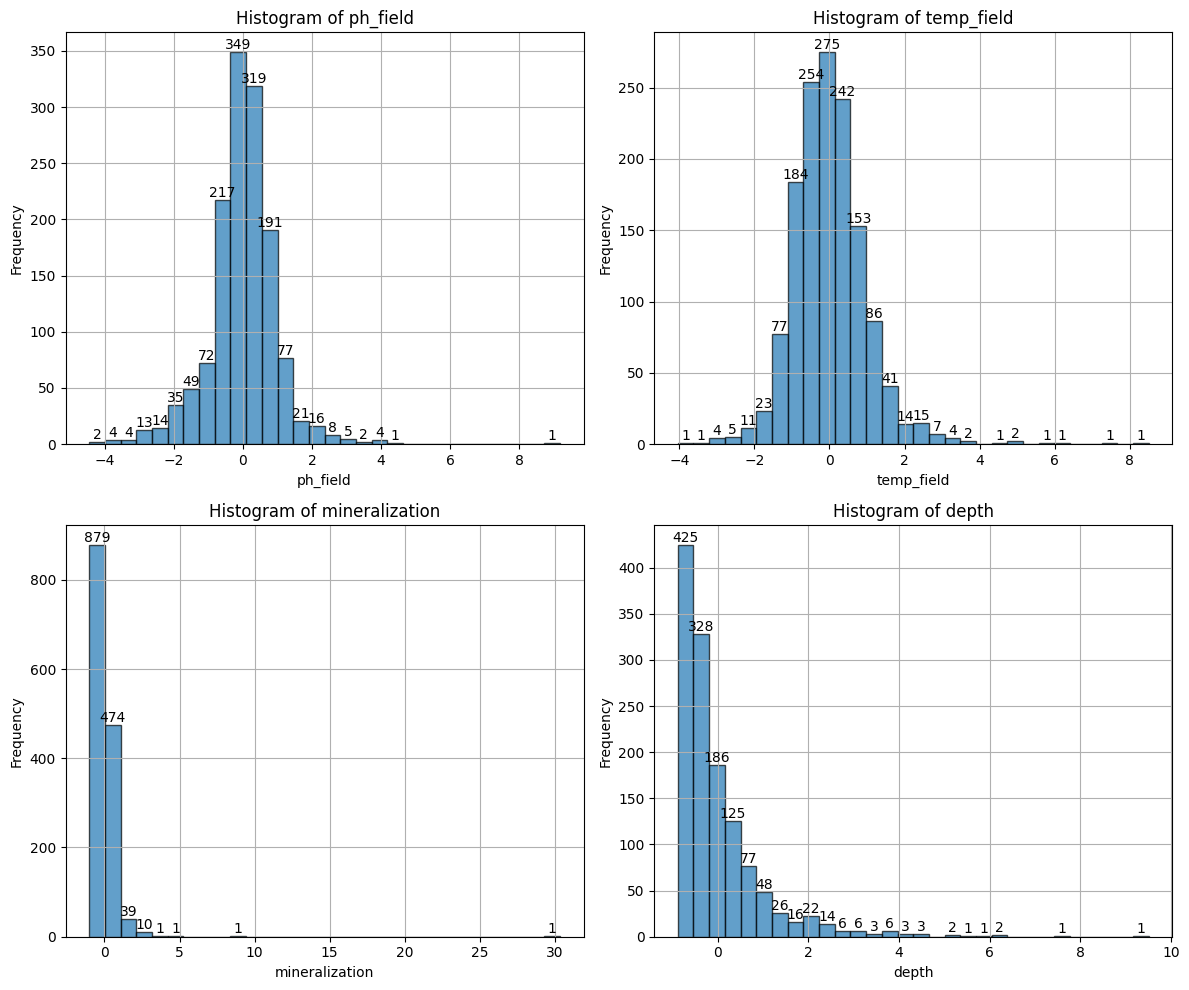

In [47]:
scaler = StandardScaler()

columns_to_scale = df_selected.columns 
df_standardized = pd.DataFrame(scaler.fit_transform(df_selected[columns_to_scale]), columns=columns_to_scale)

plot_histogram(df_standardized)

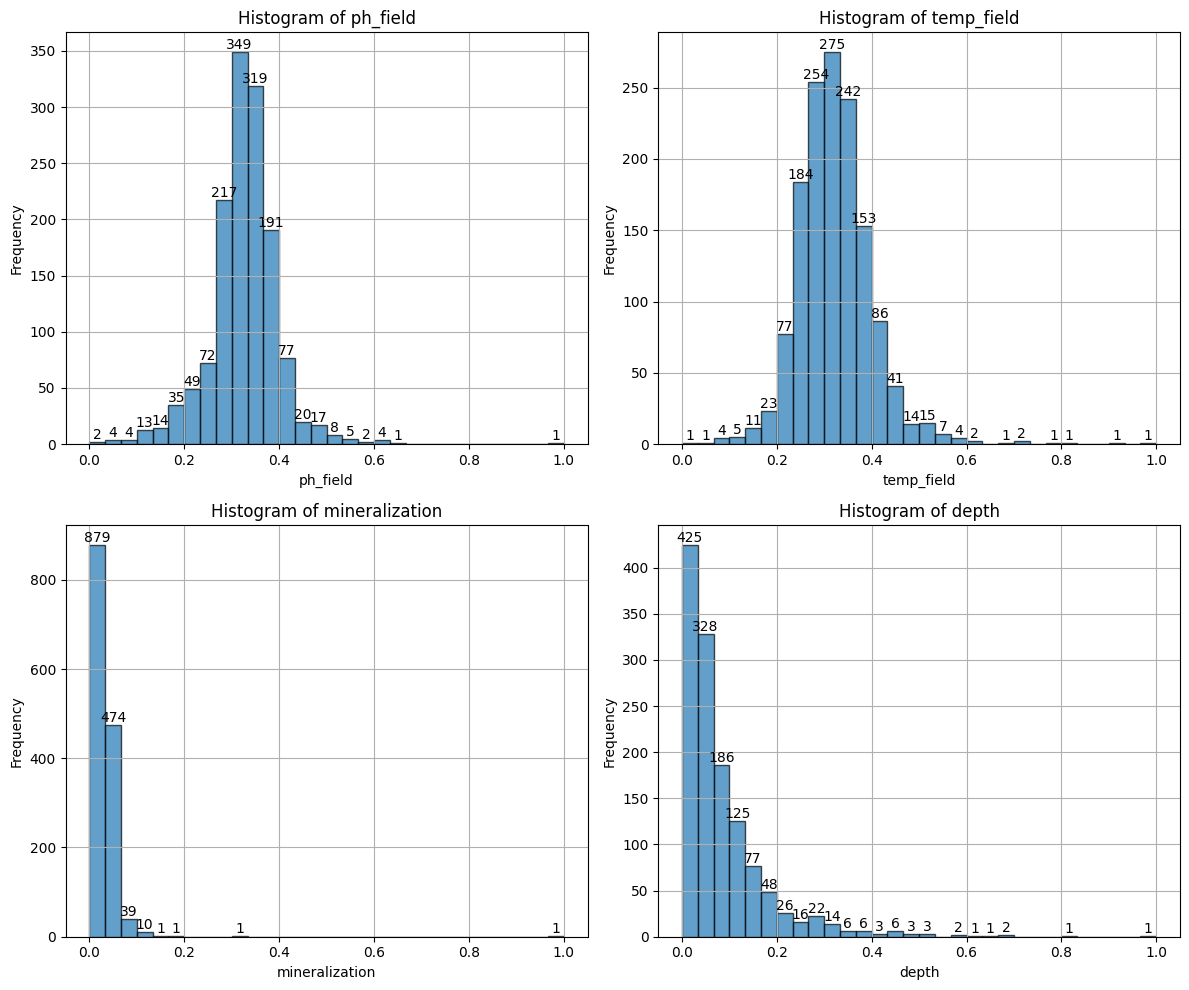

In [50]:
scaler = MinMaxScaler()

columns_to_scale = df_selected.columns  
df_normalized = pd.DataFrame(scaler.fit_transform(df_selected[columns_to_scale]), columns=columns_to_scale)

plot_histogram(df_normalized)

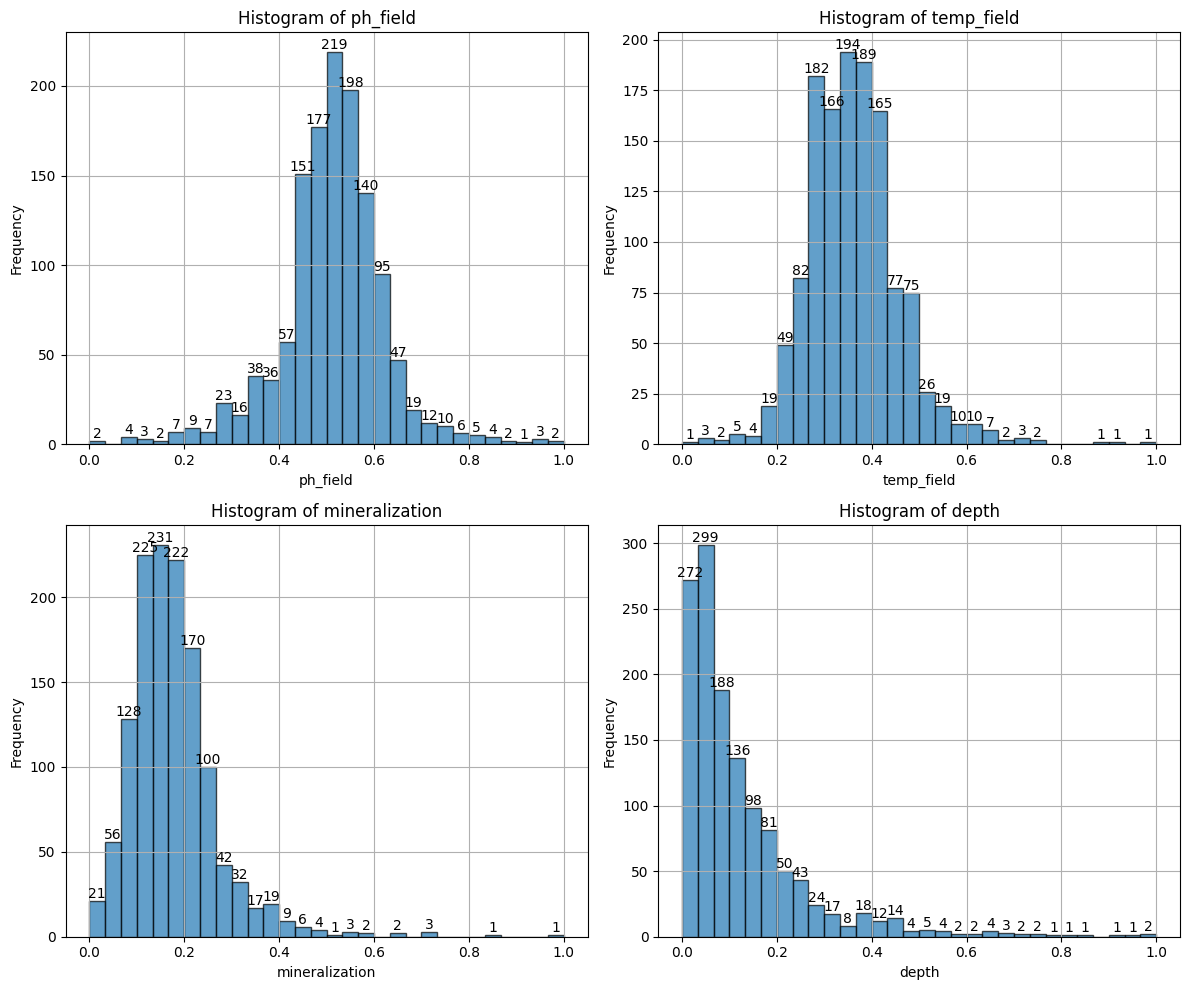

In [52]:
scaler = MinMaxScaler()

columns_to_scale = df_without_edge_values.columns  
df_normalized_without_edge_values = pd.DataFrame(scaler.fit_transform(df_without_edge_values[columns_to_scale]), columns=columns_to_scale)

plot_histogram(df_normalized_without_edge_values)

## Dependency plots

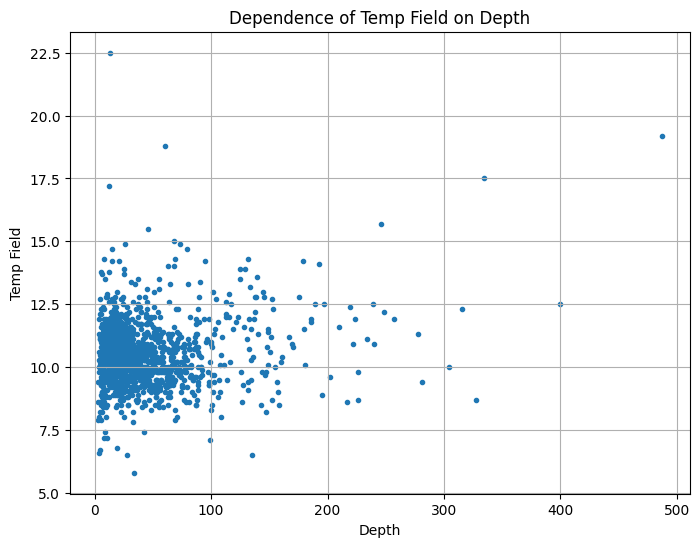

In [55]:
plt.figure(figsize=(8, 6))
plt.scatter(df_selected['depth'], df_selected['temp_field'], marker='.')
plt.title('Dependence of Temp Field on Depth')
plt.xlabel('Depth')
plt.ylabel('Temp Field')
plt.grid(True)
plt.show()

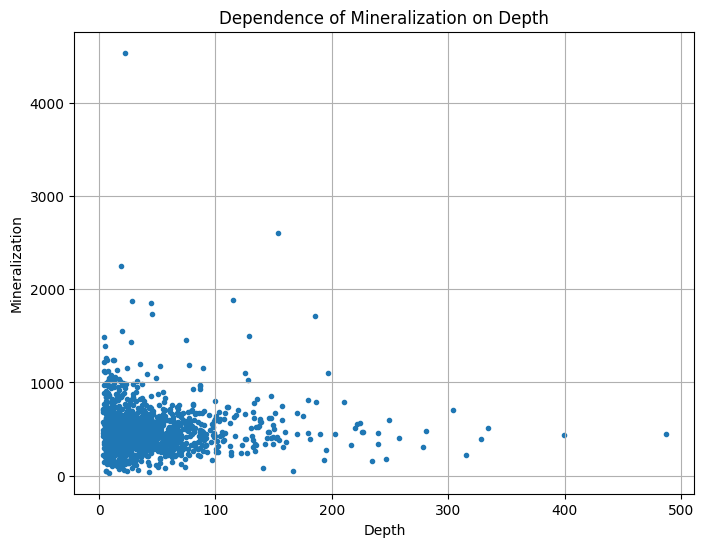

In [56]:
plt.figure(figsize=(8, 6))
plt.scatter(df_selected['depth'], df_selected['mineralization'], marker='.')
plt.title('Dependence of Mineralization on Depth')
plt.xlabel('Depth')
plt.ylabel('Mineralization')
plt.grid(True)
plt.show()

## Dependencies for data without most edge cases

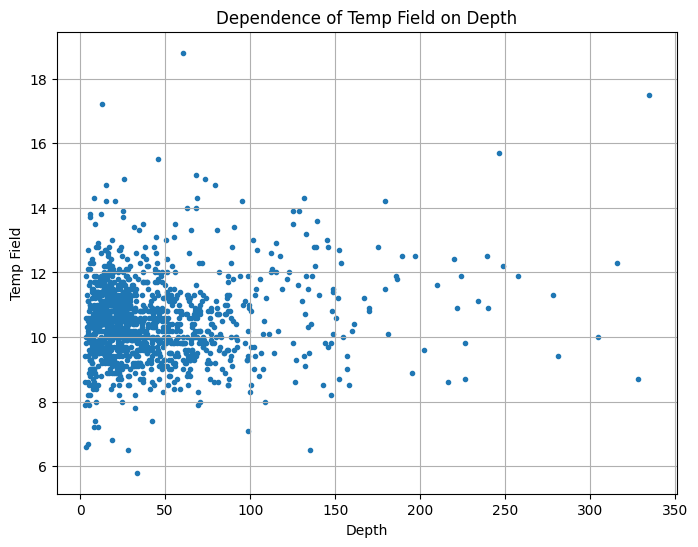

In [57]:
plt.figure(figsize=(8, 6))
plt.scatter(df_without_edge_values['depth'], df_without_edge_values['temp_field'], marker='.')
plt.title('Dependence of Temp Field on Depth')
plt.xlabel('Depth')
plt.ylabel('Temp Field')
plt.grid(True)
plt.show()

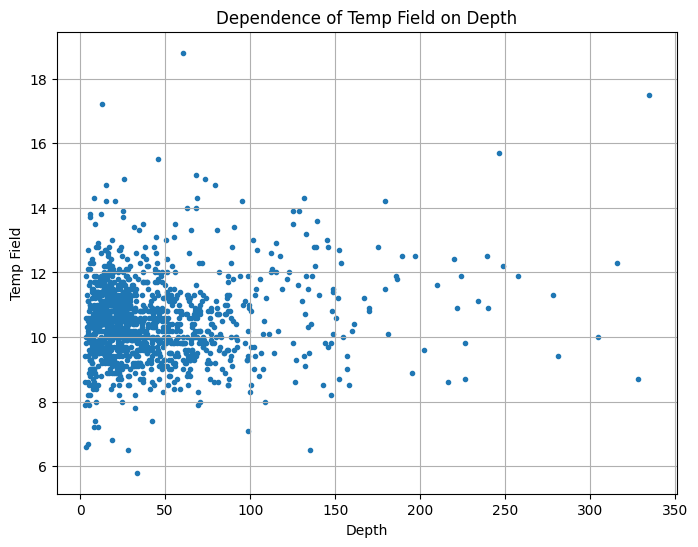

: 

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df_without_edge_values['depth'], df_without_edge_values['temp_field'], marker='.')
plt.title('Dependence of Temp Field on Depth')
plt.xlabel('Depth')
plt.ylabel('Temp Field')
plt.grid(True)
plt.show()